# Workflow for XMM EPIC-PN Large Window Mode Energy Scale Analysis

This workflow starts from an already processed event list t ospectra and already fitted Cu K$\alpha$ 8.04 keV line.

So, the previous steps are summarised below:
1. Run `pn_lw_step01.py` to download the ODF and run `cifbuild` and `odfingest`
2. Run `pn_lw_step02_x.py` to run `epchain`. There are 3 versions: x=`nocit` is with the long-term CTI correction turned off, x=`cti49` for the testing CCF file and the long-term CTI activated and x='' for running with the current CCF.
3. Run `pn_lw_step03_ccd_x.py` to run `evselect` and generate spectra. There are 3 versions: x=`nocit` is to use event lists with the long-term CTI correction turned off, x=`cti49` with event lists generated with the testing CCF file and the long-term CTI activated and x='' for event lists produced with the current CCF. There will be one spectral file per CCD. The filtering uses a mask file prepared by Michael Smith. Here is the actual filtering expression:

`(PATTERN==0) && (PAT_SEQ==0) && #XMMEA_EP && mask(mask_file_iccd,1,1,RAWX,RAWY) && (CCDNR == iccd)`

where `mask_file_iccd` is the corresponding FITS file mask for `CCD=iccd` read from here: 
`/xdata/xcaldata/XMM/PN/CTI/mask/refmask_{iccd}_mnk_lmap.fits`. The CCDNR run from 1 to 12 for EPIC-PN.

Once the per-CCD spectra are prepared then we proceed with fitting the Cu K$\alpha$ line:

4. Run script `cu_line_analysis_x.py` to fit the Cu K$\alpha$ line and store the results in `fit_results_cuka_x.csv`. There are 3 versions: x=`myproc` to use the spectra fro the current CCF, x=`nocti` to fit the spectra produced from events with the long-term CTI turned off and x=`cti49` to fit the spectra produced from events with the long-term CTI in the testing CCF.

The file with fit results is needed as an entry point in this workflow notebook.

_Ivan Valtchanov_, Feb 2019


In [1]:
#
# necessary import packages
#
import os
import numpy as np
import altair as alt
import pandas as pd

from astropy.table import Table, Column
from astropy.io import fits
#from scipy.interpolate import UnivariateSpline
home = os.path.expanduser('~')

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [2]:
def read_cti_ccf(ccf_file,mode_id=2, energy_index=0):
    #
    # utility function to read the EPN CTI calfile and get the dat ain a dictionary
    #
    # mode_id = 0 for PRIME_FULL_WINDOW
    # mode_id = 1 for PRIME_FULL_WINDOW_EXTENDED
    # mode_id = 2 for PRIME_LARGE_WINDOW
    # mode_id = 3 for PRIME_SMALL_WINDOW
    #
    # energy_index = 0 is for Al Ka at 1.486
    # energy_index = 1 is for Mn Ka at 5.8988
    # energy_index = 2 is for Fe Ka at 6.4 keV
    #
    try:
        t = Table.read(f'{ccf_file}',hdu='LONG_TERM_CTI')
        tmp = Table.read(f'{ccf_file}',hdu='LTC_TIMES')
        #times = tmp.data['TIME'][0].flatten()                           
    except:
        print (f"Cannot read CCF file {ccf_file}, it must contain extension with name \"LONG_TERM_CTI\"")
        return None
    times = tmp['TIME'][0]
    tx = t.group_by('MODE_ID')
    mmask = tx.groups.keys['MODE_ID'] == mode_id
    tenergy = tx.groups[mmask].group_by('ENERGY')
    ixxx = np.arange(len(tenergy.groups))
    if (energy_index not in ixxx):
        print (f"The index for the energy {energy_index} is not available for this mode. Only indices: ", ixxx)
        return None
    grp = tenergy.groups[energy_index]
    #print (grp)
    tout = {}
    if (mode_id != 3):
        for iccd in np.arange(1,13):
            xmask = grp['CCD_ID'] == iccd
            tcoeff = grp[xmask]['T_COEFF']
            tout[iccd] = {'mode_id': mode_id, 'ccd': iccd, 'energy': grp['ENERGY'][0],
                'times': times, 'tcoeff': tcoeff[0]}
    else:
        tcoeff = grp['T_COEFF']
        tout[0] = {'mode_id': mode_id, 'ccd': 4, 'energy': grp['ENERGY'][0],
            'times': times, 'tcoeff': tcoeff[0]}
    return tout

In [7]:
#
# read the RAWY calculated results and exrtact the mean RAWY for each CCD
# these were calculated with pn_lw_derive_rawy.py script for all OBS_IDs
#
wdir = f"{home}/IVAN/Cu-line"
t = Table.read(f'{wdir}/RAWY/all_rawy_results.csv')
df = t.to_pandas()
grouped = df.groupby('ccd')
stats = grouped['rawy'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
ccd,,,,,,,,
1,69.0,149.282609,1.898848,142.02,148.29,149.72,150.74,151.62
2,69.0,151.061594,0.489068,149.81,150.74,151.12,151.46,151.82
3,69.0,151.700870,0.365150,150.79,151.38,151.74,151.96,152.55
4,69.0,154.308116,7.964999,144.13,149.86,151.42,155.12,181.18
5,69.0,151.334058,0.478092,149.68,151.08,151.34,151.66,152.50
6,69.0,151.892464,0.426761,151.07,151.71,151.86,152.10,154.08
7,69.0,149.489130,1.886858,143.06,148.19,149.97,150.81,153.48
8,69.0,151.259420,0.523941,149.86,150.85,151.30,151.73,152.13
9,69.0,154.885942,0.381307,153.88,154.71,154.95,155.05,156.48


In [28]:
#
# read the fit results, suffix can be _myproc (CTI CCF v48), _nocti and _cti49 (testing CCF v49)
#
# will add the double events results too
# CT48
t = Table.read(f'{wdir}/fit_results_cuka_myproc.csv')
t2 = Table.read(f'{wdir}/fit_results_cuka_doubles_cti48.csv')
#t = Table.read(f'{wdir}/fit_results_cuka_doubles_cti48.csv')
#t = Table.read(f'{wdir}/fit_results_cuka_cti49.csv')
# CTI49 test51
#t = Table.read(f'{wdir}/fit_results_cuka_cti49_test51.csv')
#t2 = Table.read(f'{wdir}/fit_results_cuka_doubles_cti49_test51.csv')
t["deltaE"] = Column((t["lineE"] - 8.04)*1000.0)
t["deltaE_err"] = Column(t["lineE_err"]*1000.0)
tab = t.to_pandas()
t2["deltaE"] = Column((t2["lineE"] - 8.04)*1000.0)
t2["deltaE_err"] = Column(t2["lineE_err"]*1000.0)
tab2 = t2.to_pandas()

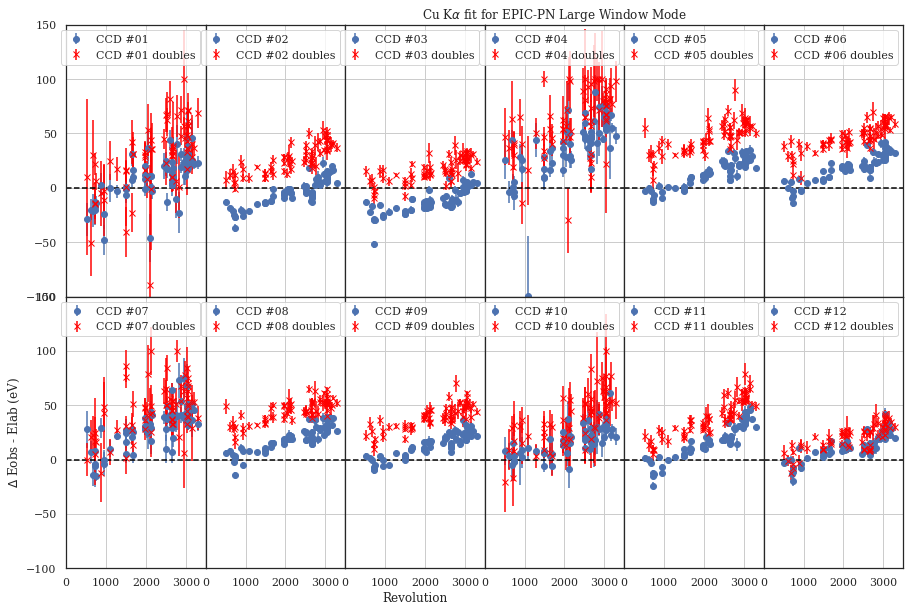

In [29]:
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    xtab = tab[tab.ccd == ccd]
    xtab2 = tab2[tab2.ccd == ccd]
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].errorbar(xtab.rev,xtab.deltaE,yerr=(xtab.deltaE_err,xtab.deltaE_err),fmt='o',label=f'CCD #{ccd:02}')
    axs[kj,k].errorbar(xtab2.rev,xtab2.deltaE,yerr=(xtab2.deltaE_err,xtab2.deltaE_err),fmt='x',color='red',label=f'CCD #{ccd:02} doubles')
    axs[kj,k].axhline(0.0,color='black',ls='dashed')
    axs[kj,k].set_xlim((0,3500))
    axs[kj,k].set_ylim((-100.0,150.0))
    axs[kj,k].grid(True)
    axs[kj,k].legend()
    if (ccd == 4):
        axs[kj,k].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 7):
        axs[kj,k].set_ylabel(r"$\Delta$ Eobs - Elab (eV)")
    if (ccd == 9):
        axs[kj,k].set_xlabel("Revolution")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
plt.savefig(f"{wdir}/cuka_results_doubles_cti48_plot.png",dpi=100)
#plt.savefig(f"{wdir}/../cuka_results_all_cti49_test51_plot.png",dpi=100)
#plt.savefig(f"{wdir}/../cuka_results_allccd_myproc_plot.png",dpi=100)
plt.show();
plt.close();

/home/ivaltchanov/miniconda3/envs/py37/lib/python3.7/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


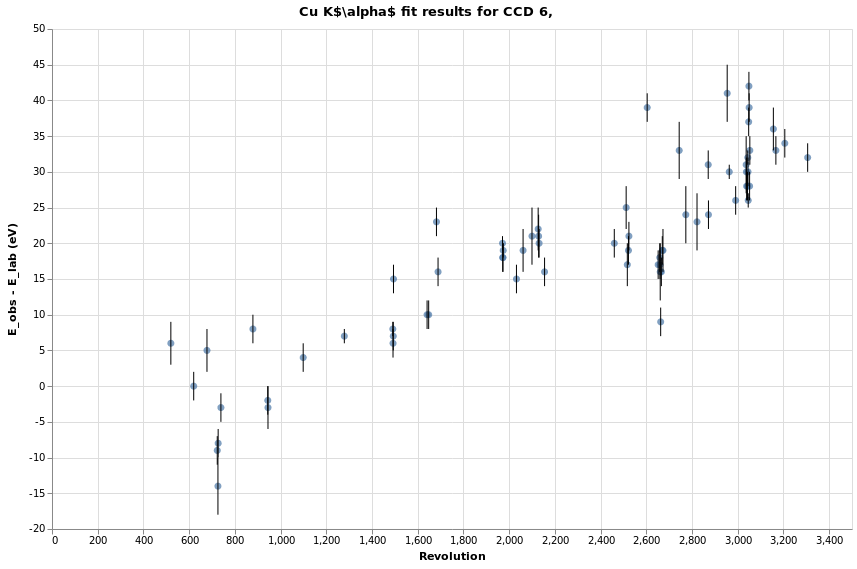

In [9]:
ccdnr = 6
xtab = tab[tab.ccd == ccdnr]

base = alt.Chart(xtab,title=fr"Cu K$\alpha$ fit results for CCD {ccdnr}, ",width=800,height=500)

points = base.mark_point(filled=True, size=50).encode(
    x=alt.X(
        "rev",
        #scale=alt.Scale(domain=(2500,3500)),
        axis=alt.Axis(title='Revolution')
    ),
    y=alt.Y(
        'deltaE',
        #scale=alt.Scale(domain=(8.0,8.2)),
        axis=alt.Axis(title="E_obs - E_lab (eV)")
    ),
    tooltip=['rev', 'obsid','lineE','ontime']
)

# generate the error bars
errorbars = base.mark_rule().encode(
    x="rev",
    y="ymin:Q",
    y2="ymax:Q"
).transform_calculate(
    ymin="datum.deltaE-datum.deltaE_err ",
    ymax="datum.deltaE+datum.deltaE_err"
)

points + errorbars

## Derive the correction with no long-term CTI processing

In [10]:
t = Table.read(f'{wdir}/fit_results_cuka_nocti.csv',comment="\s*#")
#t = Table.read(f'{wdir}/fit_results_cuka.csv')
t["ratioE"] = Column(t["lineE"]/8.04)
t["ratioE_err"] = Column(t["lineE_err"]/8.04)
tab = t.to_pandas()

### Read the current CCF file

I use CCF version 47 although the most recent one is v48, but v48 incorporates the quiescent background correction and to compare with the derived curves it's better to use the version without it.

Will also read v48 as I will reuse the first coefficient for 5.8988 keV as the normalisation of the new curve at 8.04 keV.

To derive the expected Eobs/Elab with the current calibration I will need the average RAWY.

In [11]:
#
# read the current long-term CCF, for comparison
#
al_v48 = read_cti_ccf("/xdata/ccf/pub/EPN_CTI_0048.CCF",mode_id=2,energy_index=0)
mn_v48 = read_cti_ccf("/xdata/ccf/pub/EPN_CTI_0048.CCF",mode_id=2,energy_index=1)

tt = mn_v48[1]['times']

#hdu = fits.open(f"{wdir}/../PN_SW/ccfdev/EPN_CTI_0049.CCF")
#hdu = fits.open("/xdata/ccf/pub/EPN_CTI_0047.CCF")
#tt = hdu['LTC_TIMES'].data['TIME'][0].flatten()
#ltcti = hdu['LONG_TERM_CTI'].data
##sel = np.where(ltcti['MODE_ID'] == 2)[0]
#xsel = ltcti[(ltcti['MODE_ID'] == 2) & (ltcti['ENERGY'] > 5.0)]
cti48 = {}
coef_v48 = {}
a0_v48 = {}
acti48 = {}
acoef_v48 = {}
aa0_v48 = {}
for i in range(12):
    ccd = i+1
    mean_rawy = stats['mean'].values[i]
    cti48[ccd] = {'x':[],'y':[]}
    cti48[ccd]['x'] = tt
    coef_v48[ccd] = mn_v48[ccd]['tcoeff']
    a0_v48[ccd] = coef_v48[ccd][0]
    cti48[ccd]['y'] = np.power((1.0 - coef_v48[ccd])/(1.0 - a0_v48[ccd]),mean_rawy)
    # Al Ka
    acti48[ccd] = {'x':[],'y':[]}
    acti48[ccd]['x'] = tt
    acoef_v48[ccd] = al_v48[ccd]['tcoeff']
    aa0_v48[ccd] = acoef_v48[ccd][0]
    acti48[ccd]['y'] = np.power((1.0 - acoef_v48[ccd])/(1.0 - aa0_v48[ccd]),mean_rawy)
#hdu.close()
#
# now v48
#
#hdu = fits.open("/xdata/ccf/pub/EPN_CTI_0048.CCF")
#tt = hdu['LTC_TIMES'].data['TIME'][0].flatten()
#ltcti = hdu['LONG_TERM_CTI'].data
#sel = np.where(ltcti['MODE_ID'] == 2)[0]
#xsel = ltcti[(ltcti['MODE_ID'] == 2) & (ltcti['ENERGY'] > 5.0)]
#cti48 = {}
# will keep the first coefficient
#a0_v48 = {}
#coef_v48 = {}
#for i in range(12):
#    ccd = i+1
#    mean_rawy = stats['mean'].values[i]
#    cti48[ccd] = {'x':[],'y':[]}
#    cti48[ccd]['x'] = tt
#    coef_v48[ccd] = xsel[i]['T_COEFF']
#    a0_v48[ccd] = coef_v48[ccd][0]
#    cti48[ccd]['y'] = np.power((1.0 - coef_v48[ccd])/(1.0 - a0_v48[ccd]),mean_rawy)
#hdu.close()

In [12]:
tt

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.],
      dtype=float32)

### Fit to the data

Plotting the results and incorporating a Univariate Spline fit to the data.

/home/ivaltchanov/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


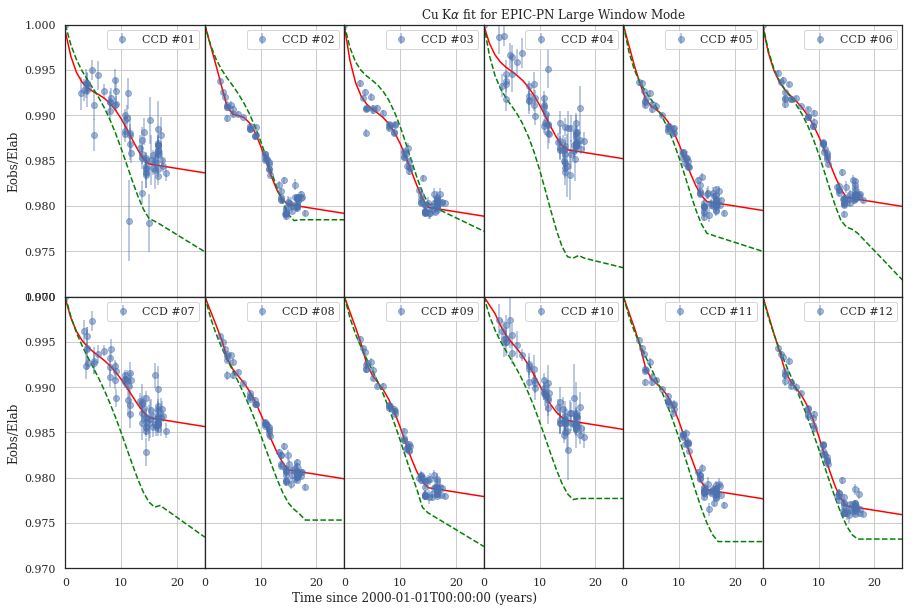

In [17]:
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
stab = tab.sort_values(['delta_time'])
#
residuals = {}
results = {}
residuals_err = {}
xout = {}
for j in range(12):
    ccd = j+1
    xtab = stab[(stab.ccd == ccd) & (stab.ratioE < 1.0)]
    #
    xin = xtab.delta_time
    yin = xtab.ratioE
    yin_err = xtab.ratioE_err
    #
    residuals[ccd] = {'x': [], 'y': [], 'yerr': []}
    #
    # now the Univariate spline
    #s = UnivariateSpline(xsp, ysp, w=weights, k=3,s=2)
    #s = UnivariateSpline(xtab.delta_time, xtab.ratioE,  k=5,s=3)
    #s = UnivariateSpline(xtab.delta_time, xtab.ratioE, k=2,s=1)
    #result = s(tt)
    #result[0] = 1.0
    #result[18:] = result[17]
    # let's try with polynomial
    #xtab12 = xtab[xtab.delta_time <= 18.0]
    #if (ccd == 1):
    #    weights = 1.0/xtab.ratioE_err
    #else:
    poly_order = 5
    #xin = pd.concat([pd.Series(0.0),xin])
    #yin = pd.concat([pd.Series(1.0),yin])
    #yin_err = pd.concat([pd.Series(1.0),yin_err])
    if (ccd == 1 or ccd == 7 or ccd == 4 or ccd == 3 or ccd == 6):
        poly_order = 4
        xin = pd.concat([pd.Series(0.0),xin])
        yin = pd.concat([pd.Series(1.0),yin])
        yin_err = pd.concat([pd.Series(1.0),yin_err])
    weights = np.ones_like(yin_err)
    weights[weights > 12.0] = 0.2
    z = np.polyfit(xin, yin,poly_order,w=weights)
    s = np.poly1d(z)
    result = s(tt)
    #
    # now make it so that from the first data point the curve goes linearly to (0.0,1.0)
    # slope m = (y2-y1)/(x2-x1) in thie case y1=1.0 and x1 = 0.0, (x2,y2) is the first data point
    m0 = (yin.values[0] - 1.0)/xin.values[0]
    i0 = int(np.ceil(xin.values[0]))
    #i0 = 3
    result[0:i0] = m0*tt[0:i0] + 1.0
    #result[0] = 1.0
    # all below the first ppoint should go to 1.0 at t=0.0 linearly
    #
    #result = np.piecewise(tt, [tt < 15, tt >= 15], [result, result[15]])
    #result[16:] = result[15]
    #
    # Test #1
    # try linear from tt=16 to tt=25 with slope as the data from [10] and [11]
    #
    # ==> result was kept in EPN_CTI_0049.CCF_test50
    #
    #istart = 15
    #m = (result[12] - result[10])/(tt[12] - tt[10])
    #result[istart:] = m*(tt[istart:] - tt[istart]) + result[istart]
    #
    # Test #2
    # ==> result was kept in EPN_CTI_0049.CCF_test51
    #
    # try linear from tt=16 to tt=25 with result[16] and result[24] = result[16]*0.999
    # as the rate of change after t=16
    xrate = 0.999
    istart = 15
    m = (result[istart]*xrate - result[istart])/(tt[-1] - tt[istart])
    result[istart:] = m*(tt[istart:] - tt[istart]) + result[istart]
    #
    #
    # now save the residuals for plotting
    #
    residuals[ccd]['y'].append(s(xin) - yin)
    residuals[ccd]['x'].append(xin)
    residuals[ccd]['yerr'].append(yin_err)
    #
    results[ccd] = result
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].errorbar(xin,yin,yerr=(yin_err,yin_err),fmt='o',label=f'CCD #{ccd:02}',alpha=0.5)
    #axs[kj,k].errorbar(xtab.rev,xtab.ratioE,yerr=(xtab.ratioE_err,xtab.ratioE_err),fmt='o',label=f'CCD #{ccd:02}')
    #axs[kj,k].axhline(0.0,color='black',ls='dashed')
    axs[kj,k].plot(tt,result,color='red')
    # now the current CCF correction
    axs[kj,k].plot(cti48[ccd]['x'],cti48[ccd]['y'],color='green',ls='dashed')
    axs[kj,k].set_xlim((0,25))
    axs[kj,k].set_ylim((0.97,1.0))
    axs[kj,k].grid(True)
    axs[kj,k].legend()
    if (ccd == 4):
        axs[kj,k].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel("Eobs/Elab")
    if (ccd == 9):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
plt.savefig(f"{wdir}/cuka_results_allccd_nocti_plot_test51.png",dpi=100)
plt.show();
plt.close();

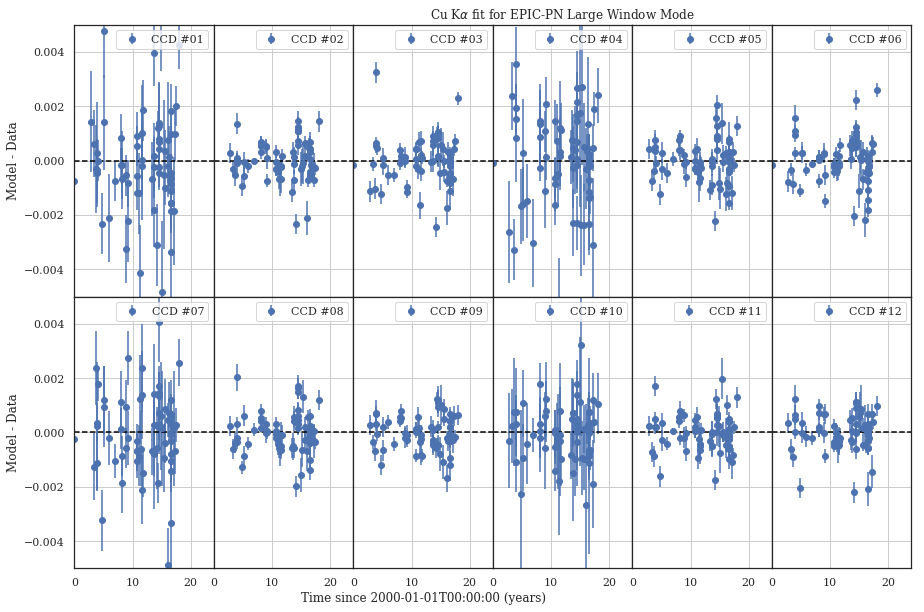

In [18]:
#
# will use the residuals from the previous cell to plot
#
fig2, axs2 = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    xtab = stab[(stab.ccd == ccd) & (stab.ratioE < 1.0)]
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs2[kj,k].errorbar(residuals[ccd]['x'],residuals[ccd]['y'],yerr=(residuals[ccd]['yerr'],residuals[ccd]['yerr']),fmt='o',label=f'CCD #{ccd:02}')
    axs2[kj,k].axhline(0.0,color='black',ls='dashed')
    axs2[kj,k].set_xlim((0,24))
    axs2[kj,k].set_ylim((-0.005,0.005))
    axs2[kj,k].grid(True)
    axs2[kj,k].legend()
    if (ccd == 4):
        axs2[kj,k].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 7 or ccd == 1):
        axs2[kj,k].set_ylabel("Model - Data")
    if (ccd == 9):
        axs2[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
plt.savefig(f"{wdir}/cuka_results_allccd_nocti_residuals_plot_test51.png",dpi=100)
plt.show();
plt.close();

## Prepare for the CCF

This step require the average RAWY per CCD and then convert the ratio Eobs/Elab to the $g(t)$  function:

$E_{obs}/E_{lab} = \left[\frac{1 - g(t)}{1-a_0}\right]^{RAWY}$,

where $a_0 = g(t_0)$, the measured CTI at launch. We know $a_0$ at 5.8988 keV but not at 8.04 keV. so we use the value for 5.8988 keV, $a_0 = 0.00043236$.

Rewriting the equation we obtain:

$g(t) = 1 - (1-a_0)\times (E_{obs}/E_{lab})^{1/RAWY}$.  

The tabulated function $g(t)$ is stored in the EPN_CTI calibartion file.

In [39]:
#
# results dictionary per CCD is the fitted Eobs/Elab (the red line).
#
gt = {}
gt2 = {}
for i in range(12):
    ccd = i + 1
    mean_rawy = stats['mean'].values[i]
    a0_x = a0_v48[ccd]
    gt[ccd] = 1.0 - (1.0 - a0_x)*np.power(results[ccd],1.0/mean_rawy)
    gt[ccd][0] = a0_v48[ccd]
    #if (ccd in [1,4,7,10]):
    #    a0_x = a0_v48[ccd]/0.95
    gt2[ccd] = 1.0 - (1.0 - a0_x)*np.power(results[ccd],1.0/mean_rawy)
    gt2[ccd][0] = a0_v48[ccd]
    if (ccd in [1,4,7,10]):
        gt2[ccd][0] = gt2[ccd][0]*0.95
    #print (f"2,{ccd},8.04,",gt[ccd])
#

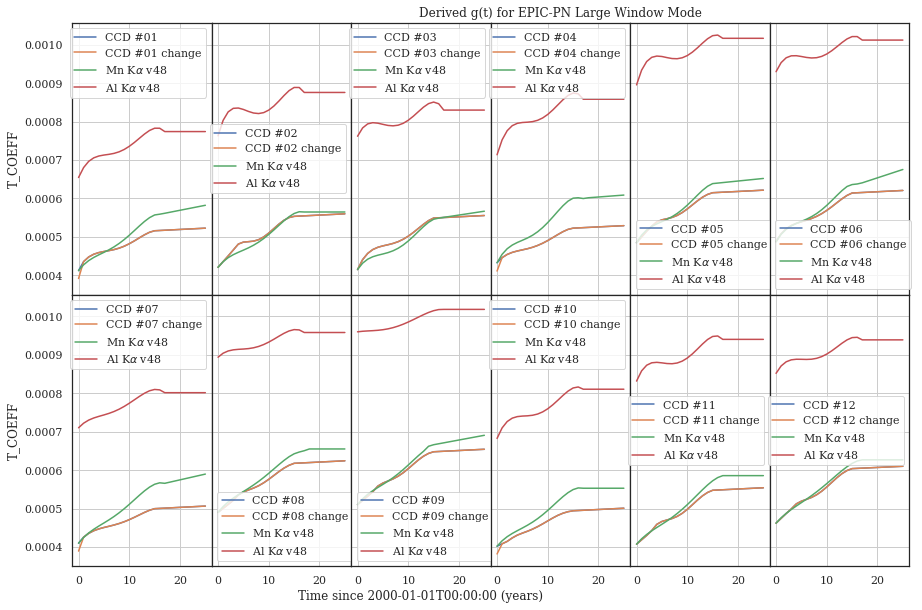

In [40]:
#
# now plot and compare
#
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].plot(tt,gt[ccd],label=f'CCD #{ccd:02}')
    axs[kj,k].plot(tt,gt2[ccd],label=f'CCD #{ccd:02} change')
    axs[kj,k].plot(cti48[ccd]['x'],coef_v48[ccd],label=r'Mn K$\alpha$ v48')
    axs[kj,k].plot(acti48[ccd]['x'],acoef_v48[ccd],label=r'Al K$\alpha$ v48')
    #axs[kj,k].plot(cti47[ccd]['x'],coef_v47[ccd],label=f'v47')
    axs[kj,k].legend()
    axs[kj,k].grid(True)
    if (ccd == 4):
        axs[kj,k].set_title("Derived g(t) for EPIC-PN Large Window Mode")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel("T_COEFF")
    if (ccd == 9):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    
#
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"{wdir}/cuka_gt_plot_test51.png",dpi=100)
plt.show();
plt.close();

## Modifying CCF file

Once all the above curves are OK we can proceed and add 12 new lines in the current CTI calibration file, at energy 8.04 keV.

In [41]:
import time
today = time.strftime("%c")
#
ccf49_file = f"{wdir}/../ccfdev/EPN_CTI_0049.CCF_test28"
hdu49 = fits.open(f"{ccf49_file}")
ltc49 = hdu49['LONG_TERM_CTI']
ix49 = np.where(ltc49.data['MODE_ID'] == 2)[0]
nrows = ltc49.data.shape[0]
xhdu = fits.BinTableHDU.from_columns(ltc49.columns, nrows=nrows+12,name='LONG_TERM_CTI',header=ltc49.header)
for j in np.arange(1,13):
    xhdu.data['MODE_ID'][j+nrows-1] = 2
    xhdu.data['CCD_ID'][j+nrows-1] = j
    xhdu.data['ENERGY'][j+nrows-1] = 8.04
    xhdu.data['T_COEFF'][j+nrows-1] = gt2[j]
    xhdu.data['SHIFT'][j+nrows-1] = 1
idx_sorted = np.lexsort((xhdu.data['ENERGY'],xhdu.data['CCD_ID'],xhdu.data['MODE_ID']))
xhdu.data = xhdu.data[idx_sorted]
xhdu.header.remove('HISTORY',remove_all=True)
xhdu.header.add_history(f'Created by Ivan V, {today}')
hdu49['LONG_TERM_CTI'] = xhdu
hdu49[0].header['FILENAME'] = "EPN_CTI_0049.CCF"
hdu49.writeto(f"{wdir}/../ccfdev/EPN_CTI_0049.CCF_test51",overwrite=True)
hdu49.close()

In [42]:
type(xhdu)

astropy.io.fits.hdu.table.BinTableHDU

In [43]:
xhdu.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  114 / length of dimension 1                          
NAXIS2  =                   91 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
EXTNAME = 'LONG_TERM_CTI'      / The name of this table                         
ALGOID  =                    5 / algorithm identifier                           
EBASE   = 5.89880000000000E+00 / [keV] reference energy for long-term CTI correc
TTYPE1  = 'MODE_ID '                                                            
TFORM1  = 'B       '        

## Check the new CCF file for consistency

In [44]:
ccf49_file = f"{wdir}/../ccfdev/EPN_CTI_0049.CCF_test51"
hdu49 = fits.open(f"{ccf49_file}")
hdu49.info()

Filename: /home/ivaltchanov/IVAN/Cu-line/../ccfdev/EPN_CTI_0049.CCF_test51
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   ()      
  1  CTI           1 BinTableHDU     15   12R x 3C   [B, E, E]   
  2  CTI_EXTENDED    1 BinTableHDU     27   768R x 9C   [B, B, B, E, E, E, E, E, E]   
  3  HOT_PIXELS    1 BinTableHDU     23   52R x 6C   [B, B, I, I, I, E]   
  4  DISCARDED_PIXELS    1 BinTableHDU     18   12R x 4C   [B, B, I, I]   
  5  CTI-HIGH      1 BinTableHDU     13   4R x 1C   [768E]   
  6  CTI-HIGH_ADD_PAR    1 BinTableHDU     25   1R x 8C   [6B, 6E, 6E, 4E, 16E, 16E, 16E, 16E]   
  7  CCD_OFFSETS    1 BinTableHDU     11   12R x 1C   [E]   
  8  TEMP_CTI      1 BinTableHDU     14   12R x 2C   [E, E]   
  9  ORSAY_GAIN    1 BinTableHDU     11   12R x 1C   [E]   
 10  LONG_TERM_CTI    1 BinTableHDU     23   91R x 5C   [B, B, E, 26E, E]   
 11  LTC_TIMES     1 BinTableHDU     12   1R x 1C   [26E]   
 12  TIMING_GAIN    1 BinTa

In [45]:
hdu49['LONG_TERM_CTI'].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  114 / length of dimension 1                          
NAXIS2  =                   91 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
EXTNAME = 'LONG_TERM_CTI'      / The name of this table                         
ALGOID  =                    5 / algorithm identifier                           
EBASE   = 5.89880000000000E+00 / [keV] reference energy for long-term CTI correc
TTYPE1  = 'MODE_ID '                                                            
TFORM1  = 'B       '        

In [46]:
#
# read the current long-term CCF, for comparison
#
al_v49 = read_cti_ccf(ccf49_file,mode_id=2,energy_index=0)
mn_v49 = read_cti_ccf(ccf49_file,mode_id=2,energy_index=1)
cu_v49 = read_cti_ccf(ccf49_file,mode_id=2,energy_index=2)


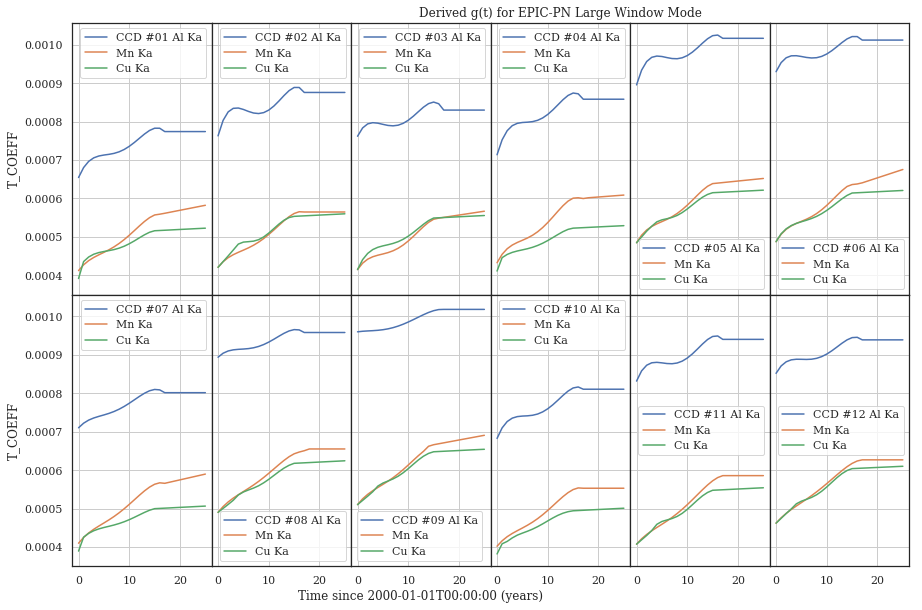

In [47]:
#
# now plot and compare
#
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].plot(al_v49[ccd]['times'],al_v49[ccd]['tcoeff'],label=f'CCD #{ccd:02} Al Ka')
    axs[kj,k].plot(mn_v49[ccd]['times'],mn_v49[ccd]['tcoeff'],label=f'Mn Ka')
    axs[kj,k].plot(cu_v49[ccd]['times'],cu_v49[ccd]['tcoeff'],label=f'Cu Ka')
    #axs[kj,k].plot(cti47[ccd]['x'],coef_v47[ccd],label=f'v47')
    axs[kj,k].legend()
    axs[kj,k].grid(True)
    if (ccd == 4):
        axs[kj,k].set_title("Derived g(t) for EPIC-PN Large Window Mode")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel("T_COEFF")
    if (ccd == 9):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(f"{wdir}/cuka_gt_plot.png",dpi=100)
plt.show();
plt.close();